## Introduction
This notebook is made for training and making predictions for our golf ball prediction project.  
This is a project where we want to get a lot of prediction data out of a video where a person hits a golf ball.


For this part of the project we will be matching the data we get from the videos with the data from simulations we ran.  
To do this we are going to use Tensorflow, more specifically a deep learning API running on top of Tensorflow called `Keras`.  

The document will be Generic, this means you can train any model if you input a JSON file.

See [Get dataset](#2-get-dataset) for more information.


At the end of this notebook we will have a trained model and we will be able to make a prediction of how hard you hit a golf ball (and some other data) on all of the video data we put in to the model.

**Make sure to use an environment with [Tensorflow](https://www.tensorflow.org/install) and [MatPlotLib](https://matplotlib.org/stable/users/installing/index.html) installed.**

If you are just starting out using Python make sure to read about [Virtual environments](https://virtualenv.pypa.io/en/latest/).

Using Google Colab you can run all of this code, simply by pressing the play button when hovering over a code block. Or to run everything in this document, go to Runtime on the top navbar --> Run everything.
See https://colab.research.google.com/notebooks/basic_features_overview.ipynb for more information about Google Colab


### Table of contents
1. Imports
1. Get dataset
1. Make or import the model
1. Train the model
1. Get plot from history
1. Save the model
1. Predict something
2. Conclusion

You can also run the following lines of code to install the required dependencies

In [11]:
!pip install tensorflow
!pip install matplotlib

  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30701 sha256=aacb0a8d51c3020126e887f2ae2691bcedcd2851289ad3ba55973f69f0bd52ae
  Stored in directory: c:\users\moren\appdata\local\pip\cache\wheels\3a\ce\7a\27094f689461801c934296d07078773603663dfcaca63bb064
Successfully built clang
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.0
    Uninstalling google-auth-2.6.0:
      Successfully uninstalled google-auth-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 20210226132247
    Uninstalling flatbuffers-20210226132247:
      Successfully uninstalled flatbuffers-20210226132247


## 1. Imports

In [1]:
import os

import numpy as np
import tensorflow as tf
import json
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

## 2. Get dataset

This function will get data from the folder `datasets` and convert every json file to [Tensorflow Tensors](https://www.tensorflow.org/api_docs/python/tf/Tensor).  
We need these Tensors because that is an expected input for training the model later.

Because the json array we get is a nested array we need to `flatten` the data first, we do this using a [Tensorflow flatten function](https://www.tensorflow.org/api_docs/python/tf/nest/flatten)  
After the input is flattened you can simply [Convert to tensor](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor) and use this tensor as an input or output when training the model.

At first we will be loading some random data in case there is no datasets directory.

To use your own data, create a `datasets` directory and put some json files in it. The block of code below will automatically find these files and use them to train the model.

In [12]:
#define some random data
random_data = """
{
    "inputs": [
      {
        "time": 1,
        "coordinatesInput": {
          "x1": 1,
          "x2": 2,
          "y1": 1,
          "y2": 2
        }
      },
      {
        "time": 2,
        "coordinatesInput": {
          "x1": 2,
          "x2": 3,
          "y1": 2,
          "y2": 3
        }
      },
      {
        "time": 3,
        "coordinatesInput": {
          "x1": 3,
          "x2": 4,
          "y1": 3,
          "y2": 4
        }
      },
      {
        "time": 4,
        "coordinatesInput": {
          "x1": 4,
          "x2": 5,
          "y1": 4,
          "y2": 5
        }
      }
    ],
    "outputs": {
      "speed": 45,
      "angle": 45,
      "spinAxis": 45,
      "distance": 45,
      "rpm": 1000,
      "resultData": [
        {
          "time": 1,
          "coordinatesOutput": {
            "x": 1,
            "y": 1,
            "z": 1
          }
        },
        {
          "time": 2,
          "coordinatesOutput": {
            "x": 2,
            "y": 2,
            "z": 2
          }
        },
        {
          "time": 3,
          "coordinatesOutput": {
            "x": 3,
            "y": 3,
            "z": 3
          }
        },
        {
          "time": 4,
          "coordinatesOutput": {
            "x": 4,
            "y": 4,
            "z": 4
          }
        }
      ]
    }
  }
"""

In [28]:
directory = os.path.join(os.getcwd(), "datasets")
all_input_files = np.array([])
input = []
output = []

if os.path.isdir(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            all_input_files = np.append(all_input_files, filename)
        else:
            continue

    for i in range(len(all_input_files)):
        x = json.load(open(os.path.join(directory, all_input_files[i])))

        print(f"input {i}:", x["inputs"], "\n")
        print(f"flattened input {i}:", tf.nest.flatten(x["inputs"]), "\n")

        input.append(tf.nest.flatten(x["inputs"]))
        output.append(tf.nest.flatten(x["outputs"]))
else:
    print("No files found in datasets directory using random data defined before")
    x = json.loads(random_data)
    print("input:", x["inputs"], "\n")
    print("flattened input:", tf.nest.flatten(x["inputs"]), "\n")

    input.append(tf.nest.flatten(x["inputs"]))
    output.append(tf.nest.flatten(x["outputs"]))

train_ds_input = tf.convert_to_tensor(input)
train_ds_output = tf.convert_to_tensor(output)

print("tensor input:", train_ds_input)



No files found in datasets directory using random data defined before
input: [{'time': 1, 'coordinatesInput': {'x1': 1, 'x2': 2, 'y1': 1, 'y2': 2}}, {'time': 2, 'coordinatesInput': {'x1': 2, 'x2': 3, 'y1': 2, 'y2': 3}}, {'time': 3, 'coordinatesInput': {'x1': 3, 'x2': 4, 'y1': 3, 'y2': 4}}, {'time': 4, 'coordinatesInput': {'x1': 4, 'x2': 5, 'y1': 4, 'y2': 5}}] 

flattened input: [1, 2, 1, 2, 1, 2, 3, 2, 3, 2, 3, 4, 3, 4, 3, 4, 5, 4, 5, 4] 

tensor input: tf.Tensor([[1 2 1 2 1 2 3 2 3 2 3 4 3 4 3 4 5 4 5 4]], shape=(1, 20), dtype=int32)


## 3. Make or import the model
This function will either:
* Import a model if it exists in the models folder
* Create a new model

For more information about a model read about it here: [ts.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

In [24]:
if os.path.exists(os.path.join(os.getcwd(), "./models/model.h5")):
    model = tf.keras.models.load_model(os.path.join(os.getcwd(), "./models/model.h5"))
    print("Model loaded")
else:
    inputs = tf.keras.Input(shape=(20,), name="inputs")
    x = tf.keras.layers.Dense(20, activation=tf.nn.relu)(inputs)
    outputs = tf.keras.layers.Dense(21, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    print("Model created")

Model loaded


## 4. Train the model

### Make callbacks
First we need to make callbacks.

There is several reasons you might want to make callbacks, we will only use it to do the following things:
We log the training process in the "logs" folder.  
We also make checkpoints everytime the accuracy increases so we can load that later if something happens like the machine crashes.

For more information about callbacks read: [tf.keras.callbacks.Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).

In [25]:
filepath="./models/weights-improvement-{epoch:02d}.hdf5"

my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max'),
]

### Train the model
Here we get to actually train the model.

We use the `train_ds_input` and `train_ds_output` we made in an earlier code block. This is the training data.  
For now there is 100 `epochs` and 100 `steps_per_epoch` this can be changed anytime. For now I will leave it like this since there is only 2 inputs and it will not train anyway.

While training a dataset you don't want to many `epochs` and `steps_per_epoch`, this is because of something called `overfit`. `overfit` occurs when you train your model too long, because of this the model we are training might be too good for the input data.
In simple terms you might say a student comes to a test already knowing the answers. Because the student already knows the answers he does not have to think about it. This will also mean that if the student would get another question he might not know the answer.

It is also not good to do to little `epochs` and `steps_per_epoch`, if you do to little something might happen called `underfit`. This means our student has not learned enough for the test and will not know the answer.

For more information about `overfit` and `underfit` see: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit.

We also need to set the callbacks to `my_callbacks` we made in the above code cell.

In [26]:
history = model.fit(train_ds_input, train_ds_output, epochs=100, steps_per_epoch=100, batch_size=8000, callbacks=my_callbacks)

Epoch 1/100
100/100 [==============================] - 1s 9ms/step - loss: -1443.4636 - accuracy: 1.0000

Epoch 00001: accuracy improved from -inf to 1.00000, saving model to ./models\weights-improvement-01.hdf5
Epoch 2/100
100/100 [==============================] - 0s 120us/step - loss: -1443.4636 - accuracy: 1.0000

Epoch 00002: accuracy did not improve from 1.00000


## 5. Get plot from history
From the training process we get all sorts of data we can use to plot to visualize how well the model has trained.

In this function we make a plot using matplotlib using the `history` from the model training.

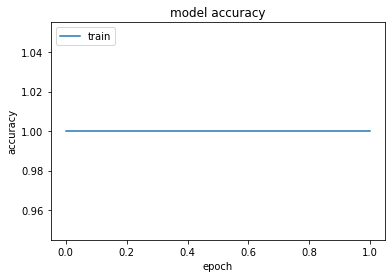

In [27]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc']) # TODO: add validation accuracy
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 6. Save the model
The model is done training and we can save it now, this way we dont have to use checkpoints each time.  
This model is reusable for next time we want to maybe train it better or make a prediction.

In [35]:
model.save("./models/model.h5")

## 7. Predict something
Here we define a functions that uses our trained model to make a prediction on the data (`input`)

In [37]:
def predict(input):
    # Make array of input
    data = []
    data.append(tf.nest.flatten(input))
    
    # Load the model
    model = tf.keras.models.load_model(os.path.join(os.getcwd(), "./models/model.h5"))
    print("Model loaded")
    
    # Make a prediction
    prediction = model.predict(tf.convert_to_tensor(data))
    prediction = prediction.tolist()
    return tf.nest.pack_sequence_as(get_structure(), prediction[0])

def get_structure():
    # Check for json files in datasets directory and return outputs for structure
    directory = os.path.join(os.getcwd(), "datasets")
    
    if os.path.isdir(directory):
        for filename in os.listdir(directory):
            if filename.endswith(".json"):
                x = json.load(open(os.path.join(directory, filename)))
                return x["outputs"]
            else:
                continue
    else:
        x = json.loads(random_data)
        return x["outputs"]

At last we can use this function to make a prediction.  
The prediction itself is not very readable since it is still a flattened array.  
To make the prediction a bit more readable we can use a Tensorflow function [tf.nest.pack_sequence_as()](https://www.tensorflow.org/api_docs/python/tf/nest/pack_sequence_as).  
In this function we use the original structure for the output.

Right here we only go through all the files in the datasets directory and make a prediction. For other predictions just **import predict** and use the `predict` function to make a prediction of a video.

In [39]:
import pprint

my_printer = pprint.PrettyPrinter(indent=4)

directory = os.path.join(os.getcwd(), "datasets")
if os.path.isdir(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            x = json.load(open(os.path.join(directory, filename)))
            my_printer.pprint(predict(x["inputs"]))
        else:
            continue
else:
    x = json.loads(random_data)
    my_printer.pprint(predict(x["inputs"]))

Model loaded
{   'angle': 2.4020595415239652e-17,
    'distance': 1.972563144726422e-13,
    'resultData': [   {   'coordinatesOutput': {   'x': 2.5846332375893726e-25,
                                                   'y': 2.4166315855871118e-21,
                                                   'z': 5.611667436176224e-26},
                          'time': 1.3249467950376927e-22},
                      {   'coordinatesOutput': {   'x': 3.854218014270142e-20,
                                                   'y': 2.3565539269749607e-23,
                                                   'z': 2.1264957643018282e-21},
                          'time': 2.5439379130332905e-20},
                      {   'coordinatesOutput': {   'x': 3.798582779432954e-17,
                                                   'y': 2.660290461261836e-23,
                                                   'z': 1.0018622154881997e-17},
                          'time': 4.651755640220052e-19},
                

## 8. Conclusion
In this notebook you have learned about the absolute basics of [Tensorflow Keras](https://keras.io/).
We have setup and trained a very simple model to predict data for calculating the trajectory of a golf ball.

There is alot of datapacks you can find on the internet, you can try and train your own model using [Tensorflow Keras](https://keras.io/guides/).

### Further read
On the [Tensorflow Keras](https://keras.io/guides/) website there is more [guides](https://keras.io/guides/) for more advanced readings about using Keras.
[Tensorflow](https://www.tensorflow.org/) has more API's then just Keras. If you want to go into `Tensorflow object detection` you can go to their site and find [Object detection](https://www.tensorflow.org/lite/examples/object_detection/overview).